<a href="https://colab.research.google.com/github/ErdemAslans/Autonomous_Driving_Segmentation_Using_ViT_and_SegFormer_with_Enhanced_Attention_Mechanisms/blob/main/Autonomous_Driving_Segmentation_Using_ViT_and_SegFormer_with_Enhanced_Attention_Mechanisms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Gerekli kütüphanelerin yüklenmesi
!pip install timm albumentations -q

# Gerekli kütüphanelerin import edilmesi
import os
import xml.etree.ElementTree as ET
import torch
import torch.nn as nn
import torch.optim as optim
import timm
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score, precision_score, recall_score
from tqdm import tqdm
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt

# Eğer GPU varsa, cihazı ayarla
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader, Subset
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch

# BDD100K'nin resmi sınıf ve renk paletleri
CLASSES = (
    "road",
    "sidewalk",
    "building",
    "wall",
    "fence",
    "pole",
    "traffic light",
    "traffic sign",
    "vegetation",
    "terrain",
    "sky",
    "person",
    "rider",
    "car",
    "truck",
    "bus",
    "train",
    "motorcycle",
    "bicycle",
)

PALETTE = [
    [128, 64, 128],
    [244, 35, 232],
    [70, 70, 70],
    [102, 102, 156],
    [190, 153, 153],
    [153, 153, 153],
    [250, 170, 30],
    [220, 220, 0],
    [107, 142, 35],
    [152, 251, 152],
    [70, 130, 180],
    [220, 20, 60],
    [255, 0, 0],
    [0, 0, 142],
    [0, 0, 70],
    [0, 60, 100],
    [0, 80, 100],
    [0, 0, 230],
    [119, 11, 32],
]

# Otomatik olarak `color_to_class` sözlüğünü oluşturma
color_to_class = {tuple(color): idx for idx, color in enumerate(PALETTE)}

# Colormap to Class Conversion
def colormap_to_class_labels(colormap, color_to_class):
    labels = np.zeros((colormap.shape[0], colormap.shape[1]), dtype=np.int64)
    for color, label in color_to_class.items():
        mask = np.all(colormap == np.array(color).reshape(1, 1, 3), axis=-1)
        labels[mask] = label
    return labels

class ColormapDataset(Dataset):
    def __init__(self, images_dir, colormaps_dir, color_to_class, transform=None):
        self.images_dir = images_dir
        self.colormaps_dir = colormaps_dir
        self.color_to_class = color_to_class
        self.transform = transform

        # Sadece görüntü ve colormap dosyalarının eşleştiğinden emin olun
        self.matched_files = [
            file for file in os.listdir(images_dir)
            if os.path.exists(os.path.join(colormaps_dir, os.path.splitext(file)[0] + '.png'))
        ]

    def __len__(self):
        return len(self.matched_files)

    def __getitem__(self, idx):
        base_name = self.matched_files[idx]
        image_path = os.path.join(self.images_dir, base_name)
        colormap_path = os.path.join(self.colormaps_dir, os.path.splitext(base_name)[0] + '.png')

        # Görüntü ve colormap yükleme
        image = np.array(Image.open(image_path).convert('RGB')).astype(np.float32) / 255.0
        colormap = np.array(Image.open(colormap_path).convert('RGB'))

        # Colormap'i sınıf etiketlerine dönüştür
        labels = colormap_to_class_labels(colormap, self.color_to_class)

        # Dönüşümleri uygula
        if self.transform:
            augmented = self.transform(image=image, mask=labels)
            image = augmented['image']
            labels = augmented['mask']

        return image, labels

# Albumentations dönüşümleri
transform = A.Compose([
    A.Resize(640, 640),
    ToTensorV2()
])

class TestImageDataset(Dataset):
    def __init__(self, images_dir, transform=None):
        self.images_dir = images_dir
        self.transform = transform
        self.image_files = os.listdir(images_dir)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.images_dir, self.image_files[idx])
        image = np.array(Image.open(image_path).convert('RGB'))

        # Dönüşümü uygula
        if self.transform:
            image = self.transform(image=image)['image']

        return image

# Eğitim ve doğrulama için veri kümesi ve DataLoader'lar
train_image_folder = '/content/drive/MyDrive/Images_Otomation/10k_images_train'
train_colormap_folder = '/content/drive/MyDrive/Images_Otomation/colormaps/train'
val_image_folder = '/content/drive/MyDrive/Images_Otomation/10k_images_val'
val_colormap_folder = '/content/drive/MyDrive/Images_Otomation/colormaps/val'

# Tüm veri kümesini yükleyin
full_train_dataset = ColormapDataset(train_image_folder, train_colormap_folder, color_to_class, transform=transform)
full_val_dataset = ColormapDataset(val_image_folder, val_colormap_folder, color_to_class, transform=transform)

# Alt küme (subset) oluşturma
train_subset_indices = np.random.choice(len(full_train_dataset), size=700, replace=False)
val_subset_indices = np.random.choice(len(full_val_dataset), size=200, replace=False)

train_dataset = Subset(full_train_dataset, train_subset_indices)
val_dataset = Subset(full_val_dataset, val_subset_indices)

# Test veri kümesi ve DataLoader oluşturma
test_image_folder = '/content/drive/MyDrive/Images_Otomation/10k_images_test'
test_dataset = TestImageDataset(test_image_folder, transform=transform)

# Test setinden 100 örnek al
test_subset_indices = np.random.choice(len(test_dataset), size=200, replace=False)
test_dataset = Subset(test_dataset, test_subset_indices)

# DataLoader'lar
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# DataLoader'ların hazır olduğuna dair kontrol
print(f"Train dataset length: {len(train_dataset)}")
print(f"Validation dataset length: {len(val_dataset)}")
print(f"Test dataset length: {len(test_dataset)}")

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Train dataset length: 700
Validation dataset length: 200
Test dataset length: 200


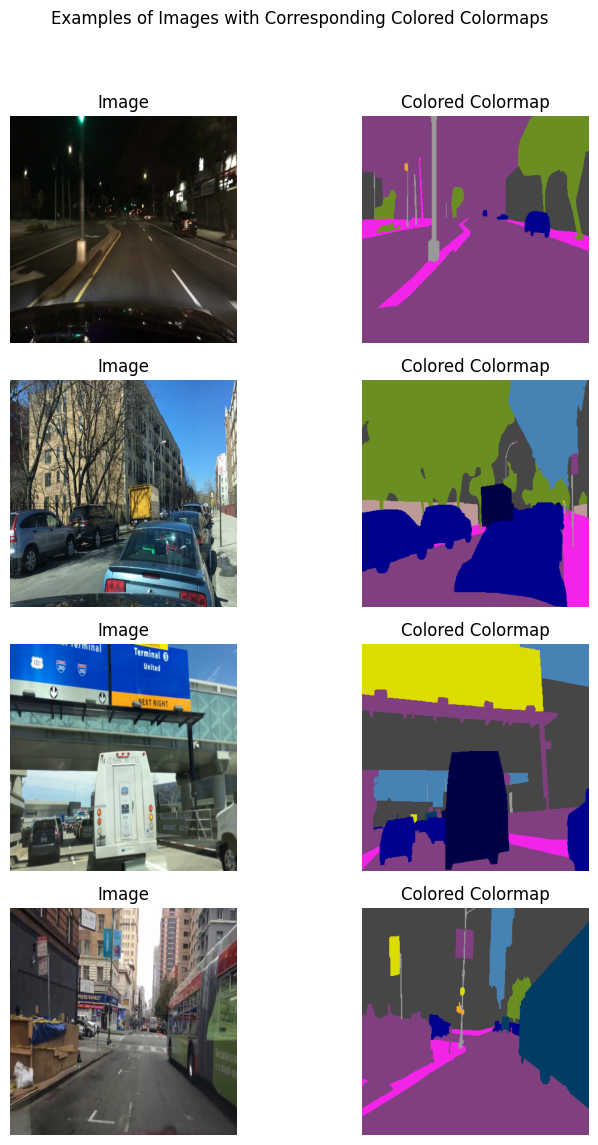

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def apply_color_map(class_map, color_to_class):
    # Sınıf haritası ile aynı boyutlarda RGB renkli harita oluştur
    h, w = class_map.shape
    colored_map = np.zeros((h, w, 3), dtype=np.uint8)

    # color_to_class sözlüğünü tersine çevirerek sınıf numaralarına renkleri atayın
    class_to_color = {v: k for k, v in color_to_class.items()}

    for class_id, color in class_to_color.items():
        # Sınıfa göre piksel seçimi ve renklendirme
        mask = class_map == class_id
        colored_map[mask] = color

    return colored_map

def visualize_colormap_examples(dataloader, color_to_class, num_examples=4):
    data_iter = iter(dataloader)
    images, class_maps = next(data_iter)

    fig, axs = plt.subplots(num_examples, 2, figsize=(8, 12))
    fig.suptitle("Examples of Images with Corresponding Colored Colormaps")

    for i in range(num_examples):
        axs[i, 0].imshow(images[i].permute(1, 2, 0).cpu().numpy())  # (C, H, W) --> (H, W, C)
        axs[i, 0].set_title("Image")
        axs[i, 0].axis("off")

        # Sınıf haritasını renklendirme ve görselleştirme
        colored_map = apply_color_map(class_maps[i].cpu().numpy(), color_to_class)
        axs[i, 1].imshow(colored_map)  # Renklendirilmiş colormap
        axs[i, 1].set_title("Colored Colormap")
        axs[i, 1].axis("off")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Eğitim veri yükleyicisinden örnekleri görselleştir
visualize_colormap_examples(train_dataloader, color_to_class)

In [ ]:
import numpy as np

def apply_color_map(class_map, color_to_class):
    # Sınıf haritasını RGB renkli haritaya çevir
    h, w = class_map.shape
    colored_map = np.zeros((h, w, 3), dtype=np.uint8)

    # Sınıf ID'lerini renklerle eşleştirme
    class_to_color = {v: k for k, v in color_to_class.items()}
    for class_id, color in class_to_color.items():
        mask = class_map == class_id
        colored_map[mask] = color

    return colored_map

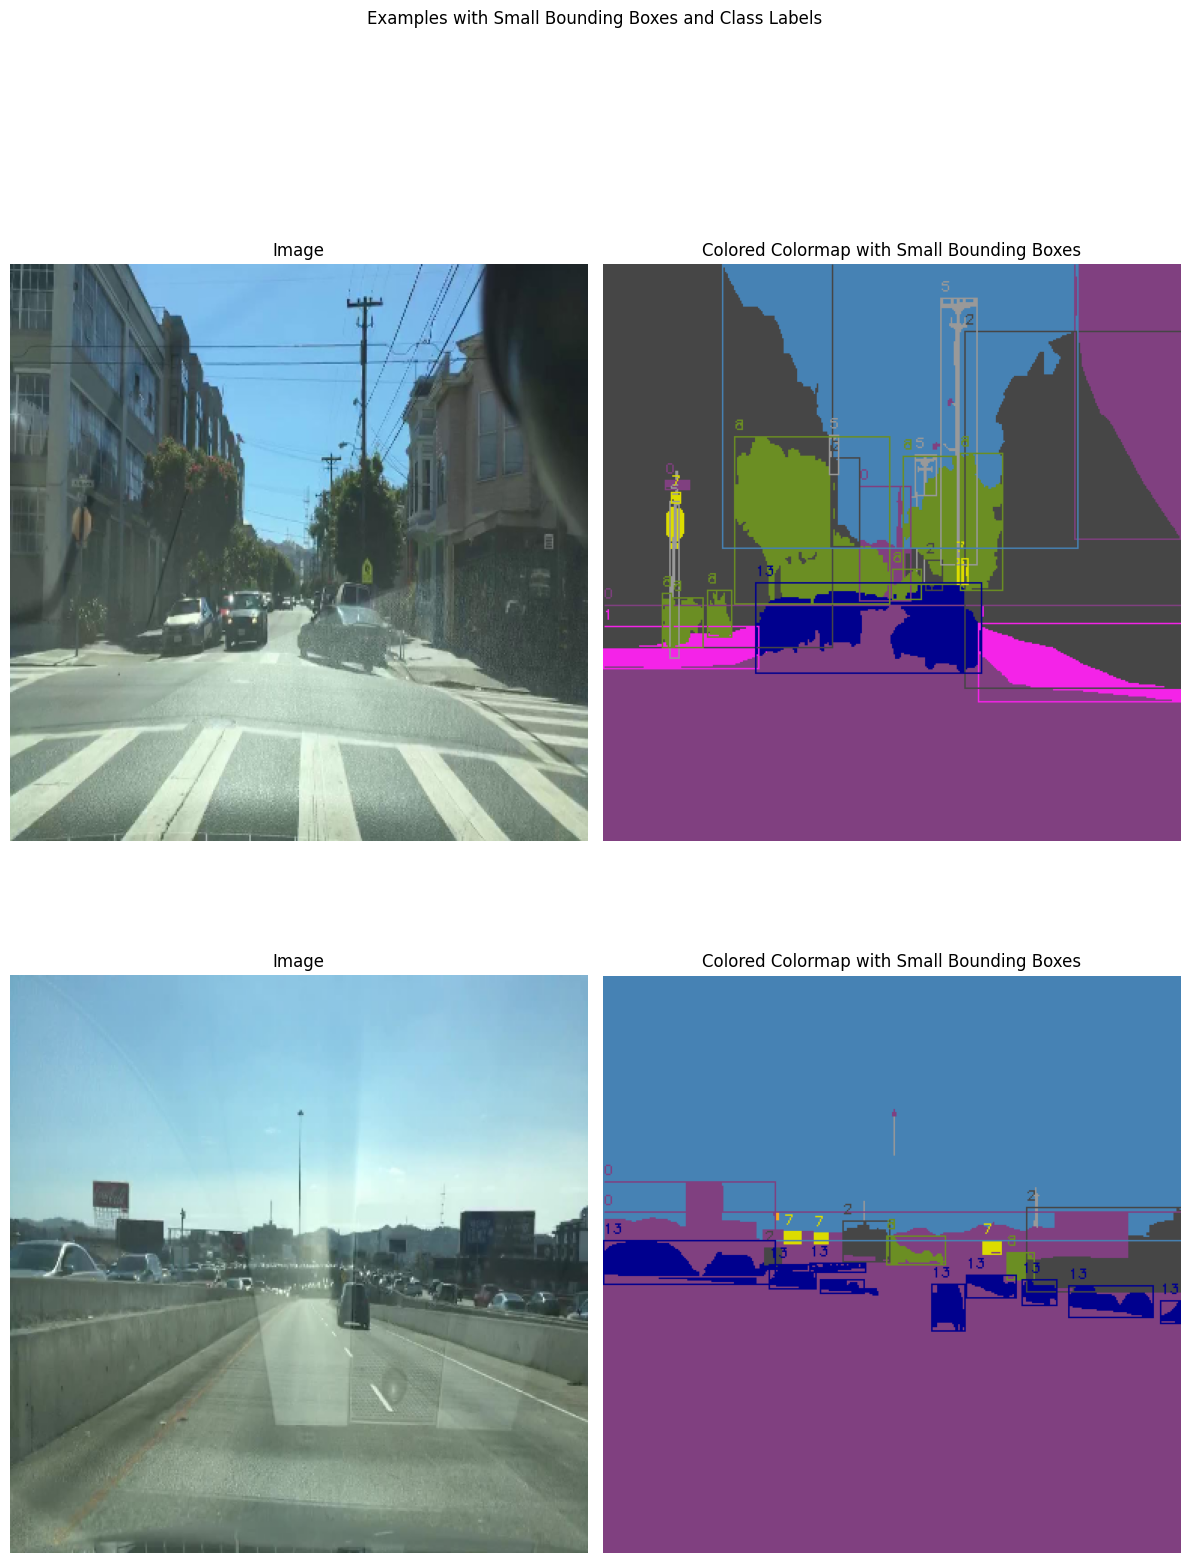

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image

# Intersection over Union (IoU) hesaplayan fonksiyon
def iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
    yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = boxA[2] * boxA[3]
    boxBArea = boxB[2] * boxB[3]

    iou_value = interArea / float(boxAArea + boxBArea - interArea)
    return iou_value

# Sıkı bounding box'lar çizmek için geliştirilmiş fonksiyon
def draw_small_bounding_boxes(colored_map, color_to_class, min_size=5, iou_threshold=0.3):
    class_to_color = {v: k for k, v in color_to_class.items()}
    output_image = colored_map.copy()

    for class_name, color in class_to_color.items():
        mask = np.all(colored_map == color, axis=-1).astype(np.uint8)
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        previous_boxes = []

        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            if w > min_size and h > min_size:
                too_close = False
                for box in previous_boxes:
                    if iou(box, (x, y, w, h)) > iou_threshold:
                        too_close = True
                        break
                if not too_close:
                    cv2.rectangle(output_image, (x, y), (x + w, y + h), color, 1)
                    cv2.putText(output_image, str(class_name), (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.3, color, 1)
                    previous_boxes.append((x, y, w, h))

    return output_image

# Class ID'lerini renklere dönüştürmek için fonksiyon
def apply_color_map(class_map, color_to_class):
    h, w = class_map.shape
    colored_map = np.zeros((h, w, 3), dtype=np.uint8)

    class_to_color = {v: k for k, v in color_to_class.items()}
    for class_id, color in class_to_color.items():
        mask = class_map == class_id
        colored_map[mask] = color

    return colored_map

# Örnek görselleştirme
def visualize_with_small_bboxes(dataloader, color_to_class, num_examples=2, min_size=5, iou_threshold=0.3):
    data_iter = iter(dataloader)
    images, class_maps = next(data_iter)

    fig, axs = plt.subplots(num_examples, 2, figsize=(12, 18))
    fig.suptitle("Examples with Small Bounding Boxes and Class Labels")

    for i in range(num_examples):
        axs[i, 0].imshow(images[i].permute(1, 2, 0).cpu().numpy())
        axs[i, 0].set_title("Image")
        axs[i, 0].axis("off")

        # Sınıf haritasını renklendirme ve küçük bounding box'larla işaretleme
        colored_map = apply_color_map(class_maps[i].cpu().numpy(), color_to_class)
        small_boxed_map = draw_small_bounding_boxes(colored_map, color_to_class, min_size=min_size, iou_threshold=iou_threshold)

        axs[i, 1].imshow(small_boxed_map)
        axs[i, 1].set_title("Colored Colormap with Small Bounding Boxes")
        axs[i, 1].axis("off")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Eğitim veri yükleyicisinden örnekleri görselleştir
visualize_with_small_bboxes(train_dataloader, color_to_class, min_size=5, iou_threshold=0.3)


In [ ]:
!pip install PyWavelets
!pip install bm3d
!pip install monai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 99.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 862.0/862.0 kB 48.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 62.5 MB/s eta 0:00:00


In [ ]:
!pip3 install openmim
!mim install mmengine
!mim install "mmcv>=2.0.0"

Looking in links: https://download.openmmlab.com/mmcv/dist/cu121/torch2.5.0/index.html
  Using cached mmengine-0.10.5-py3-none-any.whl.metadata (20 kB)
  Using cached addict-2.4.0-py3-none-any.whl.metadata (1.0 kB)
  Using cached yapf-0.40.2-py3-none-any.whl.metadata (45 kB)
Using cached mmengine-0.10.5-py3-none-any.whl (452 kB)
Using cached addict-2.4.0-py3-none-any.whl (3.8 kB)
Using cached yapf-0.40.2-py3-none-any.whl (254 kB)
Looking in links: https://download.openmmlab.com/mmcv/dist/cu121/torch2.5.0/index.html
  Using cached mmcv-2.2.0.tar.gz (479 kB)
  Preparing metadata (setup.py) ... done


In [ ]:
!git clone https://github.com/open-mmlab/mmsegmentation.git
%cd mmsegmentation
!git checkout main
!pip install -e .

In [ ]:
import torch
import torch.nn as nn
from transformers import SegformerForSemanticSegmentation

# Cihazı seç
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# SegFormer Modeli
class SimpleSegFormer(nn.Module):
    def __init__(self, num_classes):
        super(SimpleSegFormer, self).__init__()
        # SegFormer modelini yükleme
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(
            "nvidia/segformer-b5-finetuned-ade-640-640",
            num_labels=num_classes,
            ignore_mismatched_sizes=True  # Sınıf sayısı uyumsuzluğunu yoksay
        )

    def forward(self, x):
        # SegFormer'in ileri yayılımını gerçekleştirin
        outputs = self.segformer(x)
        logits = outputs.logits  # [B, num_classes, H, W]
        return logits

# Modelin tanımlanması
num_classes = 19  # BDD100K veri setinde 19 sınıf olduğu varsayımıyla
model = SimpleSegFormer(num_classes=num_classes).to(device)

# Modelin tanımlanması ve test edilmesi
sample_input = torch.randn(1, 3, 640, 640).to(device)  # Örnek girdi

with torch.no_grad():
    output = model(sample_input)
print("Model Output Shape:", output.shape)  # Çıktı: [batch_size, num_classes, height, width]


OSError: nvidia/segformer-b4-finetuned-ade-640-640 is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`

In [ ]:
!pip install openmim
!mim install mmengine
!mim install "mmcv>=2.0.0"


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.7/89.7 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 449.6/449.6 kB 21.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.5/311.5 kB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.4/239.4 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.5/506.5 kB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 7.6 MB/s eta 0:0

Looking in links: https://download.openmmlab.com/mmcv/dist/cu121/torch2.5.0/index.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.3/452.3 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.7/254.7 kB 22.2 MB/s eta 0:00:00
Looking in links: https://download.openmmlab.com/mmcv/dist/cu121/torch2.5.0/index.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 479.1/479.1 kB 8.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
y
yes



mmcv
UPerHead
ERROR: Operation cancelled by user

In [ ]:
!git clone https://github.com/open-mmlab/mmsegmentation.git
%cd mmsegmentation
!pip install -e .

Cloning into 'mmsegmentation'...
remote: Enumerating objects: 16493, done.
remote: Total 16493 (delta 0), reused 0 (delta 0), pack-reused 16493 (from 1)
Receiving objects: 100% (16493/16493), 44.23 MiB | 42.45 MiB/s, done.
Resolving deltas: 100% (11495/11495), done.
/content/mmsegmentation
Obtaining file:///content/mmsegmentation
  Preparing metadata (setup.py) ... done
  Running setup.py develop for mmsegmentation


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
from sklearn.metrics import recall_score, f1_score, accuracy_score
from torch.cuda.amp import GradScaler, autocast
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

# Dice Loss tanımı
class DiceLoss(nn.Module):
    def __init__(self, num_classes=19, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.num_classes = num_classes
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = F.softmax(inputs, dim=1)  # [B, C, H, W]
        targets = F.one_hot(targets, num_classes=self.num_classes).permute(0, 3, 1, 2).float()  # [B, C, H, W]

        inputs_flat = inputs.view(inputs.size(0), self.num_classes, -1)  # [B, C, H*W]
        targets_flat = targets.view(targets.size(0), self.num_classes, -1)  # [B, C, H*W]

        intersection = (inputs_flat * targets_flat).sum(-1)  # [B, C]
        inputs_sum = inputs_flat.sum(-1)  # [B, C]
        targets_sum = targets_flat.sum(-1)  # [B, C]

        dice_score = (2. * intersection + self.smooth) / (inputs_sum + targets_sum + self.smooth)  # [B, C]
        dice_loss = 1 - dice_score.mean()  # Ortalama Dice kaybı
        return dice_loss

# Combined Loss: Dice Loss + Cross-Entropy Loss
class CombinedDiceCELoss(nn.Module):
    def __init__(self, dice_weight=0.5, ce_weight=0.5, num_classes=19):
        super(CombinedDiceCELoss, self).__init__()
        self.dice_weight = dice_weight
        self.ce_weight = ce_weight
        self.dice_loss = DiceLoss(num_classes=num_classes)
        self.ce_loss = nn.CrossEntropyLoss()

    def forward(self, inputs, targets):
        # Dice Loss
        dice = self.dice_loss(inputs, targets)
        # Cross-Entropy Loss
        ce = self.ce_loss(inputs, targets)
        # Kombine Kayıp
        total_loss = self.dice_weight * dice + self.ce_weight * ce
        return total_loss

# Cihaz seçimi (GPU veya CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# SwinDeepLabSegmentationModel tanımlayın
model = SimpleSegFormer(num_classes=19).to(device)

# Tüm parametreleri eğitilebilir hale getirin
for param in model.parameters():
    param.requires_grad = True


# Cihaz ve model tanımı
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleSegFormer(num_classes=19).to(device)

# Kayıp fonksiyonunu ve optimizer'ı tanımla
loss_fn = CombinedDiceCELoss(dice_weight=0.5, ce_weight=0.5, num_classes=19).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=8, verbose=True)

# Eğitim ve doğrulama metriklerini takip etmek için listeler
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
train_f1_scores, val_f1_scores = [], []
train_recalls, val_recalls = [], []
train_iou_scores, val_iou_scores = [], []
train_dice_scores, val_dice_scores = [], []

# Eğitim fonksiyonu
def train_and_validate(model, train_loader, val_loader, optimizer, loss_fn, scheduler, num_epochs=30, accumulation_steps=4, num_classes=19):
    scaler = GradScaler()
    best_val_loss = float('inf')
    patience = 10  # Erken durdurma sabrı
    trigger_times = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_f1 = 0.0
        running_accuracy = 0.0
        running_recall = 0.0
        running_iou = 0.0
        running_dice = 0.0

        optimizer.zero_grad()  # Gradient'leri sıfırla

        for batch_idx, (images, colormaps) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training")):
            # Veriyi cihaza taşı
            images = images.float().to(device)
            colormaps = colormaps.long().to(device)  # Sınıf etiketleri için long tipinde

            with autocast(enabled=True):
                outputs = model(images)  # [B, num_classes, H, W]
                loss = loss_fn(outputs, colormaps)  # CombinedLoss
                loss = loss / accumulation_steps  # Normalize loss

            scaler.scale(loss).backward()

            # Gradient birikimi
            if (batch_idx + 1) % accumulation_steps == 0:
                scaler.unscale_(optimizer)  # Gradient'leri geri ölçeklendir
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)  # Gradient clipping
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()  # Gradient'leri sıfırla

            running_loss += loss.item() * accumulation_steps  # Loss'u biriktir

            # Metrikleri hesapla
            preds = torch.argmax(outputs, dim=1).cpu().numpy()  # [B, H, W]
            targets_np = colormaps.cpu().numpy()  # [B, H, W]

            recall = recall_score(targets_np.flatten(), preds.flatten(), average='macro', zero_division=0)
            f1 = f1_score(targets_np.flatten(), preds.flatten(), average='macro', zero_division=0)
            accuracy = accuracy_score(targets_np.flatten(), preds.flatten())

            running_recall += recall
            running_f1 += f1
            running_accuracy += accuracy
            running_iou += avg_iou
            running_dice += avg_dice

        # Epoch için ortalama metrikleri hesapla
        avg_loss = running_loss / len(train_loader)
        avg_f1 = running_f1 / len(train_loader)
        avg_accuracy = running_accuracy / len(train_loader)
        avg_recall = running_recall / len(train_loader)
        avg_iou = running_iou / len(train_loader)
        avg_dice = running_dice / len(train_loader)

        train_losses.append(avg_loss)
        train_f1_scores.append(avg_f1)
        train_accuracies.append(avg_accuracy)
        train_recalls.append(avg_recall)
        train_iou_scores.append(avg_iou)
        train_dice_scores.append(avg_dice)

        print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {avg_loss:.4f}, Recall: {avg_recall:.4f}, "
              f"F1 Score: {avg_f1:.4f}, Accuracy: {avg_accuracy:.4f}, IoU: {avg_iou:.4f}, Dice: {avg_dice:.4f}")

        # Doğrulama aşaması
        model.eval()
        val_loss = 0.0
        val_f1 = 0.0
        val_accuracy = 0.0
        val_recall = 0.0
        val_iou = 0.0
        val_dice = 0.0

        with torch.no_grad():
            for images, colormaps in tqdm(val_loader, desc="Validating"):
                images = images.float().to(device)
                colormaps = colormaps.long().to(device)

                outputs = model(images)  # [B, num_classes, H, W]
                loss = loss_fn(outputs, colormaps)
                val_loss += loss.item()

                preds = torch.argmax(outputs, dim=1).cpu().numpy()  # [B, H, W]
                targets_np = colormaps.cpu().numpy()  # [B, H, W]

                recall = recall_score(targets_np.flatten(), preds.flatten(), average='macro', zero_division=0)
                f1 = f1_score(targets_np.flatten(), preds.flatten(), average='macro', zero_division=0)
                accuracy = accuracy_score(targets_np.flatten(), preds.flatten())


                val_recall += recall
                val_f1 += f1
                val_accuracy += accuracy
                val_iou += avg_iou
                val_dice += avg_dice

        # Doğrulama metriklerini ortalamala
        avg_val_loss = val_loss / len(val_loader)
        avg_val_f1 = val_f1 / len(val_loader)
        avg_val_accuracy = val_accuracy / len(val_loader)
        avg_val_recall = val_recall / len(val_loader)
        avg_val_iou = val_iou / len(val_loader)
        avg_val_dice = val_dice / len(val_loader)

        val_losses.append(avg_val_loss)
        val_f1_scores.append(avg_val_f1)
        val_accuracies.append(avg_val_accuracy)
        val_recalls.append(avg_val_recall)
        val_iou_scores.append(avg_val_iou)
        val_dice_scores.append(avg_val_dice)

        print(f"Validation Loss: {avg_val_loss:.4f}, Recall: {avg_val_recall:.4f}, F1 Score: {avg_val_f1:.4f}, "
              f"Accuracy: {avg_val_accuracy:.4f}, IoU: {avg_val_iou:.4f}, Dice: {avg_val_dice:.4f}")

        # Scheduler güncelle
        scheduler.step(avg_val_loss)

        # En iyi modeli kaydet ve erken durdurmayı uygula
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            print(f"Yeni en iyi model kaydedildi (Validation Loss: {best_val_loss:.4f})")
            trigger_times = 0
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print("Erken durdurma tetiklendi")
                break

        # GPU belleğini temizle
        del images, colormaps, outputs, loss
        torch.cuda.empty_cache()

# Eğitim sonrası metrikleri görselleştirme
def plot_metrics():
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(24, 6))

    # Kayıp grafiği
    plt.subplot(1, 6, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Doğruluk grafiği
    plt.subplot(1, 6, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # F1 Skoru grafiği
    plt.subplot(1, 6, 3)
    plt.plot(epochs, train_f1_scores, label='Training F1 Score')
    plt.plot(epochs, val_f1_scores, label='Validation F1 Score')
    plt.title('F1 Score over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()

    # Recall grafiği
    plt.subplot(1, 6, 4)
    plt.plot(epochs, train_recalls, label='Training Recall')
    plt.plot(epochs, val_recalls, label='Validation Recall')
    plt.title('Recall over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()

    # IoU grafiği
    plt.subplot(1, 6, 5)
    plt.plot(epochs, train_iou_scores, label='Training IoU')
    plt.plot(epochs, val_iou_scores, label='Validation IoU')
    plt.title('IoU over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.legend()

    # Dice grafiği
    plt.subplot(1, 6, 6)
    plt.plot(epochs, train_dice_scores, label='Training Dice')
    plt.plot(epochs, val_dice_scores, label='Validation Dice')
    plt.title('Dice over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Dice')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Modeli eğitme ve performansı izleme
train_and_validate(model, train_dataloader, val_dataloader, optimizer, loss_fn, scheduler, num_epochs=25)


# Eğitim sonrası metrikleri görselleştirme
plot_metrics()




Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b5-finetuned-ade-640-640 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 768, 1, 1]) in the checkpoint and torch.Size([19, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([19]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b5-finetuned-ade-640-640 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 768, 1, 1]) in the checkpoint and torch.Size([19, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) 

RuntimeError: The size of tensor a (25600) must match the size of tensor b (409600) at non-singleton dimension 2

In [ ]:
# Albumentations dönüşümleri
test_transform = A.Compose([
    A.Resize(384, 384),
    ToTensorV2()
])

class TestImageDataset(Dataset):
    def __init__(self, images_dir, transform=None):
        self.images_dir = images_dir
        self.transform = transform
        self.image_files = os.listdir(images_dir)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.images_dir, self.image_files[idx])
        image = np.array(Image.open(image_path).convert('RGB'))

        # Dönüşümü uygula
        if self.transform:
            image = self.transform(image=image)['image']

        return image



# Test dataset ve DataLoader oluşturma
test_image_folder = '/content/drive/MyDrive/Images_Otomation/10k_images_test'
test_dataset = TestImageDataset(test_image_folder, transform=test_transform)
test_subset = Subset(test_dataset, test_indices)
test_dataloader = DataLoader(test_subset, batch_size=32, shuffle=False, num_workers=4)


Encoder Input Shape: torch.Size([32, 3, 384, 384])
Before Permute Encoder Output Shape: torch.Size([32, 12, 12, 1536])
After Permute Encoder Output Shape: torch.Size([32, 1536, 12, 12])
Decoder Input Shape: torch.Size([32, 1536, 12, 12])
ASPP Input Shape: torch.Size([32, 1536, 12, 12])
ASPP Atrous Block 1 Output Shape: torch.Size([32, 256, 12, 12])
ASPP Atrous Block 6 Output Shape: torch.Size([32, 256, 12, 12])
ASPP Atrous Block 12 Output Shape: torch.Size([32, 256, 12, 12])
ASPP Atrous Block 18 Output Shape: torch.Size([32, 256, 12, 12])
ASPP Image Pooling Output Shape: torch.Size([32, 256, 1, 1])
ASPP After Interpolation Shape: torch.Size([32, 256, 12, 12])
ASPP Concatenated Shape: torch.Size([32, 1280, 12, 12])
ASPP Output Shape: torch.Size([32, 256, 12, 12])
After ASPP in Decoder Shape: torch.Size([32, 256, 12, 12])
Decoder Output Shape: torch.Size([32, 19, 12, 12])
Final Segmentation Shape: torch.Size([32, 19, 384, 384])
Encoder Input Shape: torch.Size([32, 3, 384, 384])
Before Pe

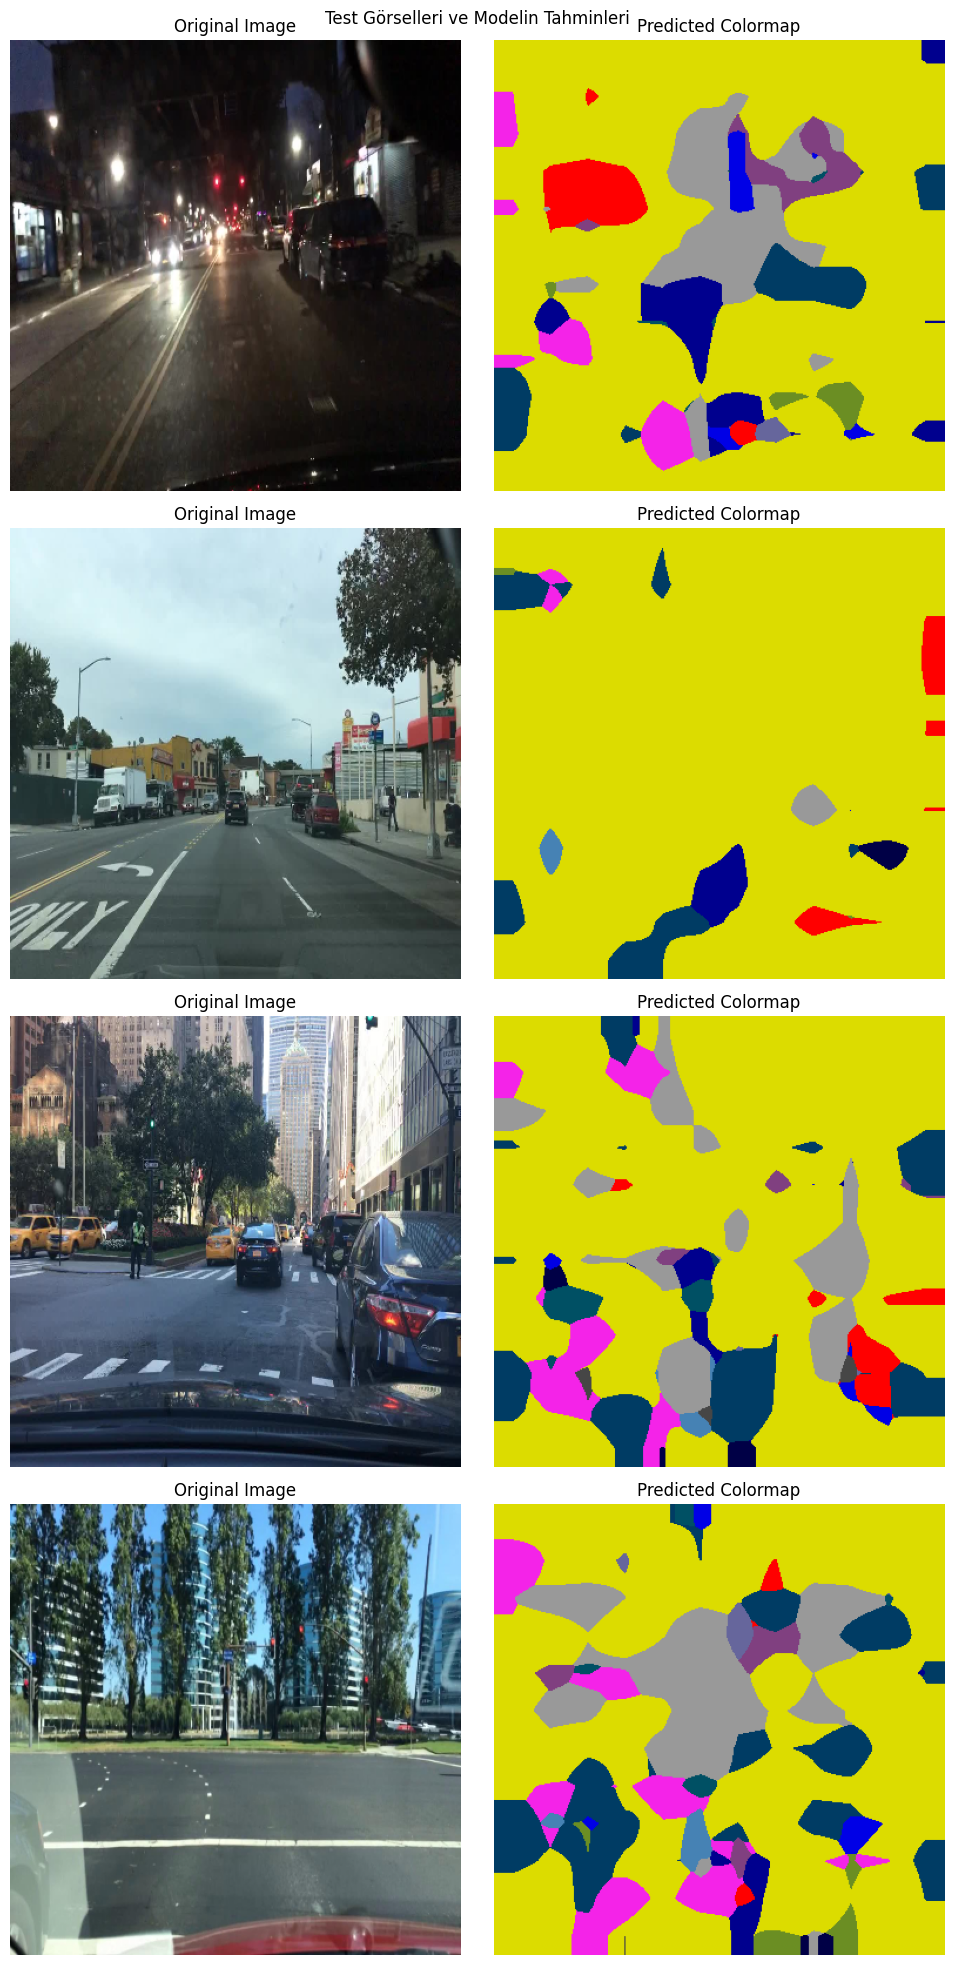

In [ ]:
import matplotlib.pyplot as plt
import torch
from monai.transforms import AsDiscrete

# Albumentations dönüşümü
test_transform = A.Compose([
    A.Resize(384, 384),
    ToTensorV2()
])

def test_model_with_visualization(model, test_loader, device, color_to_class):
    model.eval()
    post_trans = AsDiscrete(threshold=0.5)  # Model çıktısını ikili hale getirme

    fig, axs = plt.subplots(4, 2, figsize=(10, 20))
    fig.suptitle("Test Görselleri ve Modelin Tahminleri")

    with torch.no_grad():
        for idx, images in enumerate(test_loader):
            if idx >= 4:  # Sadece 4 örnek gösterelim
                break

            # Eğer tek kanallı ise, 3 kanala dönüştür
            if images.ndim == 3:
                images = images.unsqueeze(1)
            if images.shape[1] == 1:
                images = images.repeat(1, 3, 1, 1)

            images = images.float().to(device)

            # Modelin tahminleri
            outputs = model(images)
            outputs = torch.argmax(outputs, dim=1).cpu().numpy()  # [B, H, W]

            # Görsel ve tahminlerin görselleştirilmesi
            for i in range(min(len(images), 1)):  # Sadece ilk resmi gösterelim
                # Orijinal görüntüyü [0, 1] aralığına ölçeklendir
                img = images[i].permute(1, 2, 0).cpu().numpy()
                img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0, 1]

                # Orijinal görüntüyü göster
                axs[idx, 0].imshow(img)
                axs[idx, 0].set_title("Original Image")
                axs[idx, 0].axis("off")

                # Model tahminini renklendirerek göster
                colormap_prediction = apply_color_map(outputs[i], color_to_class)
                axs[idx, 1].imshow(colormap_prediction)
                axs[idx, 1].set_title("Predicted Colormap")
                axs[idx, 1].axis("off")

    plt.tight_layout()
    plt.show()

# Test verisi ve modeli değerlendir
test_model_with_visualization(model, test_dataloader, device, color_to_class)

In [ ]:
# Visualize predictions on test dataset
visualize_test_predictions(model, test_dataloader, color_to_class, device, num_examples=4)


In [ ]:
mport torch
import torch.nn as nn
import torch.nn.functional as F
import timm  # For Swin Transformer

# Custom ASPP Module (from torchvision's DeepLab implementation)
class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ASPP, self).__init__()
        self.atrous_block1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, dilation=1, padding=0, bias=False)
        self.atrous_block6 = nn.Conv2d(in_channels, out_channels, kernel_size=3, dilation=6, padding=6, bias=False)
        self.atrous_block12 = nn.Conv2d(in_channels, out_channels, kernel_size=3, dilation=12, padding=12, bias=False)
        self.atrous_block18 = nn.Conv2d(in_channels, out_channels, kernel_size=3, dilation=18, padding=18, bias=False)
        self.image_pool = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        self.conv1 = nn.Conv2d(out_channels * 5, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        print("ASPP Input Shape:", x.shape)
        x1 = self.atrous_block1(x)
        print("ASPP Atrous Block 1 Output Shape:", x1.shape)
        x2 = self.atrous_block6(x)
        print("ASPP Atrous Block 6 Output Shape:", x2.shape)
        x3 = self.atrous_block12(x)
        print("ASPP Atrous Block 12 Output Shape:", x3.shape)
        x4 = self.atrous_block18(x)
        print("ASPP Atrous Block 18 Output Shape:", x4.shape)
        x5 = self.image_pool(x)
        print("ASPP Image Pooling Output Shape:", x5.shape)
        x5 = F.interpolate(x5, size=x4.size()[2:], mode='bilinear', align_corners=False)
        print("ASPP After Interpolation Shape:", x5.shape)
        x = torch.cat((x1, x2, x3, x4, x5), dim=1)
        print("ASPP Concatenated Shape:", x.shape)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        print("ASPP Output Shape:", x.shape)
        return x

# Custom Decoder
class DeepLabDecoder(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(DeepLabDecoder, self).__init__()
        self.aspp = ASPP(in_channels, 256)
        self.conv1 = nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(256)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Conv2d(256, num_classes, kernel_size=1)

    def forward(self, x):
        print("Decoder Input Shape:", x.shape)
        x = self.aspp(x)
        print("After ASPP in Decoder Shape:", x.shape)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.classifier(x)
        print("Decoder Output Shape:", x.shape)
        return x

# Swin Encoder
class SwinEncoder(nn.Module):
    def __init__(self, img_size=384, embed_dim=1024):
        super(SwinEncoder, self).__init__()
        self.swin = timm.create_model('swin_large_patch4_window12_384', pretrained=True, features_only=True)
        # Extract the last feature map's channel dimension
        self.swin_out_channels = self.swin.feature_info.channels()[-1]

    def forward(self, x):
        print("Encoder Input Shape:", x.shape)
        features = self.swin(x)
        x = features[-1]  # [Batch, Channels, Height, Width] or [Batch, Height, Width, Channels]
        print("Before Permute Encoder Output Shape:", x.shape)
        # Check if the tensor is in [N, C, H, W]. If not, permute it.
        if x.dim() == 4 and x.shape[1] != self.swin_out_channels:
            x = x.permute(0, 3, 1, 2).contiguous()  # Convert [N, H, W, C] to [N, C, H, W]
            print("After Permute Encoder Output Shape:", x.shape)
        else:
            print("No permutation needed. Encoder Output Shape:", x.shape)
        return x

# Swin + Custom DeepLabV3+ Decoder Segmentation Model
class SwinDeepLabSegmentationModel(nn.Module):
    def __init__(self, num_classes=19):
        super(SwinDeepLabSegmentationModel, self).__init__()
        self.encoder = SwinEncoder()
        # Initialize decoder with encoder's output channels (1536)
        self.decoder = DeepLabDecoder(in_channels=self.encoder.swin_out_channels, num_classes=num_classes)

    def forward(self, x):
        features = self.encoder(x)  # [Batch, Channels, Height, Width]
        segmentation = self.decoder(features)
        # Upsample to original image size
        segmentation = F.interpolate(segmentation, size=x.shape[2:], mode='bilinear', align_corners=False)
        print("Final Segmentation Shape:", segmentation.shape)
        return segmentation

# Model and device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SwinDeepLabSegmentationModel(num_classes=19).to(device)

# Set the model to evaluation mode to handle BatchNorm layers correctly during testing
model.eval()

# Test the model with sample input
sample_input = torch.randn(1, 3, 384, 384).to(device)
with torch.no_grad():
    output = model(sample_input)
print("Model Output Shape:", output.shape)